In [1]:
from lightly.loss import NTXentLoss
from lightly.models.modules import (
    NNCLRPredictionHead,
    NNCLRProjectionHead,
    NNMemoryBankModule,
)
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import umap
import umap.plot
import wandb
import yaml

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lopez\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\lopez\anaconda3\envs\jku-pr\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:

data_path = os.path.join(os.getcwd(), "features_mae_large/")
model_path = r"C:\Users\lopez\Projects\jku-pr\models"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load each YAML file into a dictionary
def load_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

classid_to_names = load_yaml(os.path.join(data_path, "in1k_classid_to_names.yaml"))
class_to_classid = load_yaml(os.path.join(data_path, "in1k_class_to_classid.yaml"))
class_to_classname = load_yaml(os.path.join(data_path, "in1k_class_to_classname.yaml"))

### Understand Data

In [4]:
test_center_crop = torch.load(data_path + "mae_l23_cls_test_centercrop.th")
print(test_center_crop.shape)
del test_center_crop

torch.Size([50000, 1024])


In [29]:
train_center_crop = torch.load(data_path + "mae_l23_cls_train_centercrop.th")
print(train_center_crop.shape)
del train_center_crop

KeyboardInterrupt: 

In [ ]:
v1_seed0 = torch.load(data_path + "tensors_v1_seed_0.th")
print(v1_seed0.shape)
del v1_seed0

torch.Size([1281167, 1024])


In [8]:
v1_seed2 = torch.load(data_path + "tensors_v1_seed_2.th")
print(v1_seed2.shape)
del v1_seed2

torch.Size([1281167, 1024])


In [9]:
v1_seed3 = torch.load(data_path + "tensors_v1_seed_3.th")
print(v1_seed3.shape)
del v1_seed3

torch.Size([1281167, 1024])


In [10]:
v1_seed4 = torch.load(data_path + "tensors_v1_seed_4.th")
print(v1_seed4.shape)
del v1_seed4

torch.Size([1281167, 1024])


In [11]:
v1_seed5 = torch.load(data_path + "tensors_v1_seed_5.th")
print(v1_seed5.shape)
del v1_seed5

torch.Size([1281167, 1024])


In [12]:
v1_seed6 = torch.load(data_path + "tensors_v1_seed_6.th")
print(v1_seed6.shape)
del v1_seed6

torch.Size([1281167, 1024])


In [13]:
v2_seed0 = torch.load(data_path + "tensors_v2_seed_0.th")
print(v2_seed0.shape)
del v2_seed0

torch.Size([1281167, 1024])


In [14]:
v2_seed1 = torch.load(data_path + "tensors_v2_seed_1.th")
print(v2_seed1.shape)
del v2_seed1

torch.Size([1281167, 1024])


In [15]:
v2_seed2 = torch.load(data_path + "tensors_v2_seed_2.th")
print(v2_seed2.shape)
del v2_seed2

torch.Size([1281167, 1024])


In [16]:
v2_seed3 = torch.load(data_path + "tensors_v2_seed_3.th")
print(v2_seed3.shape)
del v2_seed3

torch.Size([1281167, 1024])


In [17]:
v2_seed4 = torch.load(data_path + "tensors_v2_seed_4.th")
print(v2_seed4.shape)
del v2_seed4

torch.Size([1281167, 1024])


In [18]:
v2_seed5 = torch.load(data_path + "tensors_v2_seed_5.th")
print(v2_seed5.shape)
del v2_seed5

torch.Size([1281167, 1024])


In [19]:
v2_seed6 = torch.load(data_path + "tensors_v2_seed_6.th")
print(v2_seed6.shape)
del v2_seed6

torch.Size([1281167, 1024])


In [20]:
test_labels = torch.load(data_path + "test-labels.th")
print(test_labels.shape)
print(test_labels[0:10])
print(test_labels.unique().shape)
del test_labels

torch.Size([50000])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([1000])


In [21]:
train_labels = torch.load(data_path + "train-labels.th")
print(train_labels.shape)
print(train_labels.unique().shape)
del train_labels

torch.Size([1281167])
torch.Size([1000])


## Group Classes

In [16]:
# dictionary for higher-level categories for UMAP visualization
categories = {
    'animals': 'animal.n.01',   
    'vehicles': 'vehicle.n.01', 
    'household': 'artifact.n.01',
    'food': 'food.n.01',
    'nature': 'natural_object.n.01'
}

# just a function to help with checking if category exists
def check_synset_exists(synset_name):
    try:
        # Attempt to fetch the synset using the provided name
        syn = wn.synset(synset_name)
        return True, syn.definition()  # Return True and the definition if it exists
    except nltk.corpus.reader.wordnet.WordNetError:
        return False, None  # Return False and None if the synset does not exist

def get_category(labels, categories, class_to_classid):
    category_names = list(categories.keys())
    synset_list = list(categories.values())
    
    for synset_name in synset_list:
        if not check_synset_exists(synset_name):
            raise ValueError(
                f"The synset '{synset_name}' is not valid."
                )
    
    # initialize list to store category labels
    category_labels = []
    # loop through all labels
    for label in labels:
        # get the class_id from the class_to_classid dictionary
        class_id = class_to_classid[label.item()]
        synset = wn.synset_from_pos_and_offset('n', int(class_id[1:]))
        searching = True
        while searching:
            # check if the synset is in the synset_list
            if synset.name() in synset_list:
                # if it is, add the category to the category_labels list
                category_labels.append(synset_list.index(synset.name()))
                searching = False
            else:
                try:
                    # if it is not, move up the hypernym tree
                    synset = synset.hypernyms()[0]
                except:
                    # if there are no more hypernyms, add -1 to the category_labels list
                    category_labels.append(-1)
                    searching = False

    return category_names, category_labels

In [17]:
test_labels = torch.load(data_path + "test-labels.th")
category_names, category_labels = get_category(test_labels, categories, class_to_classid)

In [18]:
torch.Tensor(category_labels).unique(return_counts=True)

(tensor([-1.,  0.,  1.,  2.,  3.,  4.]),
 tensor([ 2050, 19900,  1200, 24900,  1100,   850]))

In [19]:
print(category_names)

['animals', 'vehicles', 'household', 'food', 'nature']


### Model Stuff

In [8]:
class MAEDataset(torch.utils.data.Dataset):
    def __init__(self, view1_path, view2_path):

        self.data1 = torch.load(view1_path)
        self.data2 = torch.load(view2_path)
        assert self.data1.shape == self.data2.shape, "view1 and view2 must have the same shape"
        self.length = self.data1.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.data1[idx], self.data2[idx]

In [9]:
class NNCLRHead(nn.Module):
    def __init__(self, project_hidden_dim, project_output_dim, 
                 predict_hidden_dim, predict_output_dim):
        super().__init__()

        self.projection_head = NNCLRProjectionHead(1024, # input_dim 
                                                   project_hidden_dim, # hidden_dim 
                                                   project_output_dim) # output_dim
        self.prediction_head = NNCLRPredictionHead(project_output_dim, # input_dim 
                                                   predict_hidden_dim, # hidden_dim
                                                   predict_output_dim) # output_dim
        
        self.proj_activation = None
        self.hook = self.projection_head.layers[2].register_forward_hook(self.capture_activations)
    
    def capture_activations(self, module, input, output):
        self.proj_activation = output

    def forward(self, x):
        z = self.projection_head(x)
        p = self.prediction_head(z)
        z = z.detach()
        return self.proj_activation, z, p
    
    def remove_hook(self):
        self.hook.remove()

In [10]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 4096
LR = 0.4 # 0.3
TEMPERATURE = 0.15
QUEUE_SIZE = 98304
WEIGHT_DECAY = 1e-6
PROJECT_HIDDEN_DIM = 2048
PROJECT_OUTPUT_DIM = 256
PREDICTION_HIDDEN_DIM = 4096
PREDICTION_OUTPUT_DIM = 256

# Training

In [10]:
view1_path = os.path.join(data_path, "tensors_v1_seed_0.th").replace("\\", "/")
view2_path = os.path.join(data_path, "tensors_v2_seed_0.th").replace("\\", "/")

In [13]:
model = NNCLRHead(PROJECT_HIDDEN_DIM, 
                  PROJECT_OUTPUT_DIM, 
                  PREDICTION_HIDDEN_DIM, 
                  PREDICTION_OUTPUT_DIM)
model.to(device)
memory_bank = NNMemoryBankModule(size=(QUEUE_SIZE, PREDICTION_OUTPUT_DIM))
memory_bank.to(device)
criterion = NTXentLoss(temperature=TEMPERATURE, memory_bank_size=(QUEUE_SIZE, PREDICTION_OUTPUT_DIM))
optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

dataset = MAEDataset(view1_path, view2_path)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)


print("Starting Training")
for epoch in range(EPOCHS):
    total_loss = 0
    for x0, x1 in dataloader:
        x0, x1 = x0.to(device), x1.to(device)
        _, z0, p0 = model(x0)
        _, z1, p1 = model(x1)
        z0 = memory_bank(z0, update=False) # update can be True for z0 xor z1
        z1 = memory_bank(z1, update=True)
        loss = 0.5 * (criterion(z0, p1) + criterion(z1, p0))
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    # random sample
    # knn fit
    # knn prediction

Starting Training
epoch: 00, loss: 5.76129
epoch: 01, loss: 5.59256
epoch: 02, loss: 5.57957
epoch: 03, loss: 5.57321
epoch: 04, loss: 5.57425
epoch: 05, loss: 5.57750
epoch: 06, loss: 5.58436
epoch: 07, loss: 5.59258
epoch: 08, loss: 5.59940
epoch: 09, loss: 5.60792


In [14]:
torch.cuda.empty_cache()

In [7]:
# save model checkpoint
model_name = "nnclr_head_test1.pth"
# torch.save(model.state_dict(), os.path.join(model_path, model_name))

In [13]:
# load model checkpoint
model = NNCLRHead(PROJECT_HIDDEN_DIM, 
                  PROJECT_OUTPUT_DIM, 
                  PREDICTION_HIDDEN_DIM, 
                  PREDICTION_OUTPUT_DIM)
model.load_state_dict(torch.load(os.path.join(model_path, model_name)))
model.to(device)

NNCLRHead(
  (projection_head): NNCLRProjectionHead(
    (layers): Sequential(
      (0): Linear(in_features=1024, out_features=2048, bias=False)
      (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=2048, out_features=2048, bias=False)
      (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=2048, out_features=256, bias=False)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (prediction_head): NNCLRPredictionHead(
    (layers): Sequential(
      (0): Linear(in_features=256, out_features=4096, bias=False)
      (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=4096, out_features=256, bias=True)
    )
  )
)

# UMAP

In [18]:
# load the test set
test_features = torch.load(os.path.join(data_path, "mae_l23_cls_test_centercrop.th"))
test_dataloader = torch.utils.data.DataLoader(test_features, 
                                              batch_size=1,
                                              shuffle=False)

In [19]:
model.eval()
with torch.inference_mode():
    test_embeddings = []
    for x in test_dataloader:
        x = x.to(device)
        l, z, p = model(x)
        test_embeddings.append(p.cpu())

In [20]:
reducer = umap.UMAP()
test_embeddings = torch.cat(test_embeddings, axis = 0)
embedding = reducer.fit_transform(test_embeddings)
embedding.shape

(50000, 2)

C:\Users\lopez\AppData\Local\Temp\ipykernel_19468\2626005214.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(unique_labels))


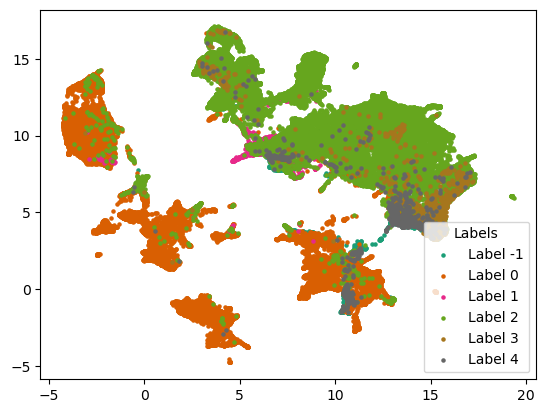

In [21]:
fig, ax = plt.subplots()
unique_labels = np.unique(category_labels)

colors = plt.cm.get_cmap('Dark2', len(unique_labels))

#scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c = colors, alpha=0.5, s = 5)

for i, label in enumerate(unique_labels):
    ax.scatter(embedding[:, 0][category_labels == label], embedding[:, 1][category_labels == label], color=colors(i), label=f'Label {label}', s = 5)

ax.legend(title="Labels")
plt.show()

# k-NN

In [23]:
# randomly sample 10% of training data and use as training set for k-NN classifier
# sampling needs to be deterministic
# sampling can be done after a training epoch and can be seen as a form of a "test set" 
torch.manual_seed(42)
train_features = torch.load(os.path.join(data_path, "mae_l23_cls_train_centercrop.th"))
train_labels = torch.load(os.path.join(data_path, "train-labels.th"))
train_indices = torch.randperm(len(train_labels))[:int(0.1*len(train_labels))]
train_features = train_features[train_indices]
train_labels = train_labels[train_indices]

# Pass train features through the model
model.eval()
with torch.inference_mode():
    train_embeddings = []
    for x in train_features:
        x = x.unsqueeze(0).to(device)
        _, z, p = model(x)
        train_embeddings.append(p.cpu())

In [24]:
# normalize the embeddings
train_embeddings = torch.cat(train_embeddings, axis = 0)
train_emb = train_embeddings.numpy()
train_x = normalize(train_emb, norm='l2', axis=1)
# print(test_x)


# fit a k-nearest neighbor classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='cosine')
knn.fit(train_x, train_labels.numpy())

#Define the test x
test_x = test_embeddings.numpy()
test_x = normalize(test_x, norm='l2', axis=1)

prediction = knn.predict(test_x[0:10])
print(prediction)

[394   0   0   0   0   0   0   0   0   0]


# Less Class Training

In [30]:
# remove x number of classes from the training set and see how the model performs
def remove_classes_randomly(features, labels, num_classes_to_remove=10):
    unique_labels = labels.unique() # 1000
    classes_to_remove = torch.randperm(len(unique_labels))[:num_classes_to_remove]
    mask = torch.ones(len(labels), dtype=torch.bool)
    for c in classes_to_remove:
        mask = mask & (labels != c) # if labels == c, mask = False and if labels != c, mask = True
    return features[mask], labels[mask]

# remove 100 classes from the training set
reduced_train_features, reduced_train_labels = remove_classes_randomly(train_features, train_labels, 100)

print(len(reduced_train_labels))
print(len(train_labels))
print(len(reduced_train_labels)/len(train_labels))

115322
128116
0.90013737550345


In [ ]:
def remove_classes_by_category(features, labels, num_classes_to_remove, category_to_remove, method):
    pass